In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = []
        self.labels = []

        self.class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        print(self.class_to_idx)

        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            for file in os.listdir(class_dir):
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(class_dir, file))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


dataset = ImageDataset('/kaggle/input/animals-detection-images-dataset/train', transform=transform_train)

train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.labels)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


{'Bear': 0, 'Brown bear': 1, 'Bull': 2, 'Butterfly': 3, 'Camel': 4, 'Canary': 5, 'Caterpillar': 6, 'Cattle': 7, 'Centipede': 8, 'Cheetah': 9, 'Chicken': 10, 'Crab': 11, 'Crocodile': 12, 'Deer': 13, 'Duck': 14, 'Eagle': 15, 'Elephant': 16, 'Fish': 17, 'Fox': 18, 'Frog': 19, 'Giraffe': 20, 'Goat': 21, 'Goldfish': 22, 'Goose': 23, 'Hamster': 24, 'Harbor seal': 25, 'Hedgehog': 26, 'Hippopotamus': 27, 'Horse': 28, 'Jaguar': 29, 'Jellyfish': 30, 'Kangaroo': 31, 'Koala': 32, 'Ladybug': 33, 'Leopard': 34, 'Lion': 35, 'Lizard': 36, 'Lynx': 37, 'Magpie': 38, 'Monkey': 39, 'Moths and butterflies': 40, 'Mouse': 41, 'Mule': 42, 'Ostrich': 43, 'Otter': 44, 'Owl': 45, 'Panda': 46, 'Parrot': 47, 'Penguin': 48, 'Pig': 49, 'Polar bear': 50, 'Rabbit': 51, 'Raccoon': 52, 'Raven': 53, 'Red panda': 54, 'Rhinoceros': 55, 'Scorpion': 56, 'Sea lion': 57, 'Sea turtle': 58, 'Seahorse': 59, 'Shark': 60, 'Sheep': 61, 'Shrimp': 62, 'Snail': 63, 'Snake': 64, 'Sparrow': 65, 'Spider': 66, 'Squid': 67, 'Squirrel': 68, 

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(dataset.class_to_idx)

from torchvision.models import resnet18

model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch {epoch+1} | Loss: {running_loss:.4f} | Train Acc: {acc:.2f}%")

    # Валидация
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_acc = 100. * val_correct / val_total
    print(f"Validation Acc: {val_acc:.2f}%\n")


Epoch 1 | Loss: 1662.3748 | Train Acc: 27.69%
Validation Acc: 32.96%

Epoch 2 | Loss: 1279.6784 | Train Acc: 40.44%
Validation Acc: 42.16%

Epoch 3 | Loss: 1089.5305 | Train Acc: 47.88%
Validation Acc: 43.89%

Epoch 4 | Loss: 969.3489 | Train Acc: 52.81%
Validation Acc: 47.25%

Epoch 5 | Loss: 854.0633 | Train Acc: 56.71%
Validation Acc: 46.99%

Epoch 6 | Loss: 768.7571 | Train Acc: 59.92%
Validation Acc: 49.65%

Epoch 7 | Loss: 677.0027 | Train Acc: 64.60%
Validation Acc: 47.90%

Epoch 8 | Loss: 608.6914 | Train Acc: 67.66%
Validation Acc: 50.64%

Epoch 9 | Loss: 544.2439 | Train Acc: 70.58%
Validation Acc: 52.77%

Epoch 10 | Loss: 481.6359 | Train Acc: 73.58%
Validation Acc: 50.53%



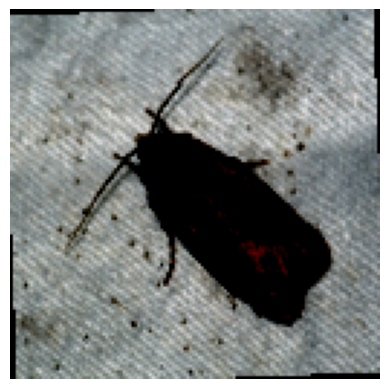

Moths and butterflies


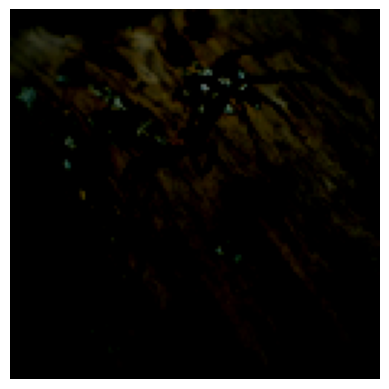

Centipede


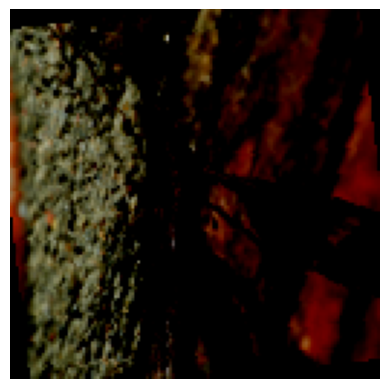

Spider


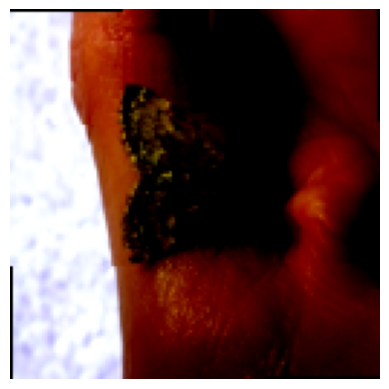

Moths and butterflies


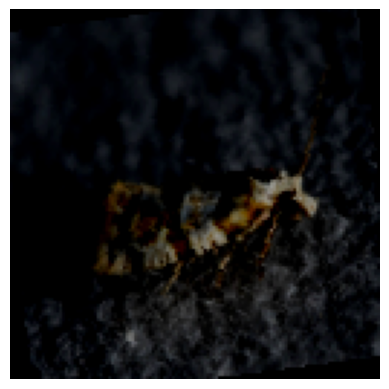

Moths and butterflies


In [16]:
import matplotlib.pyplot as plt
kol = 0
for images, labels in val_loader:
    if kol == 5:
        break
    else:
        kol+=1
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        images = images.to('cpu')
        image = images[0].permute(1, 2, 0).numpy()
        
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        print(dataset.class_names[predicted[0]])



In [17]:
dataset_test = ImageDataset('/kaggle/input/animals-detection-images-dataset/test', transform=transform_train)
dataset_test_data = DataLoader(dataset_test, batch_size=32, shuffle=False)


model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in dataset_test_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
test_acc = 100. * test_correct / test_total
print(f"Validation Acc: {val_acc:.2f}%\n")


{'Bear': 0, 'Brown bear': 1, 'Bull': 2, 'Butterfly': 3, 'Camel': 4, 'Canary': 5, 'Caterpillar': 6, 'Cattle': 7, 'Centipede': 8, 'Cheetah': 9, 'Chicken': 10, 'Crab': 11, 'Crocodile': 12, 'Deer': 13, 'Duck': 14, 'Eagle': 15, 'Elephant': 16, 'Fish': 17, 'Fox': 18, 'Frog': 19, 'Giraffe': 20, 'Goat': 21, 'Goldfish': 22, 'Goose': 23, 'Hamster': 24, 'Harbor seal': 25, 'Hedgehog': 26, 'Hippopotamus': 27, 'Horse': 28, 'Jaguar': 29, 'Jellyfish': 30, 'Kangaroo': 31, 'Koala': 32, 'Ladybug': 33, 'Leopard': 34, 'Lion': 35, 'Lizard': 36, 'Lynx': 37, 'Magpie': 38, 'Monkey': 39, 'Moths and butterflies': 40, 'Mouse': 41, 'Mule': 42, 'Ostrich': 43, 'Otter': 44, 'Owl': 45, 'Panda': 46, 'Parrot': 47, 'Penguin': 48, 'Pig': 49, 'Polar bear': 50, 'Rabbit': 51, 'Raccoon': 52, 'Raven': 53, 'Red panda': 54, 'Rhinoceros': 55, 'Scorpion': 56, 'Sea lion': 57, 'Sea turtle': 58, 'Seahorse': 59, 'Shark': 60, 'Sheep': 61, 'Shrimp': 62, 'Snail': 63, 'Snake': 64, 'Sparrow': 65, 'Spider': 66, 'Squid': 67, 'Squirrel': 68, 

In [18]:
print(f"Test Acc: {val_acc:.2f}%\n")

Test Acc: 50.53%

